In [ ]:
# Link: https://colab.research.google.com/drive/1Pqta4oD-jaZ5--2W1KzlhEdu5LMCXSdt?usp=sharing

# Install

In [ ]:
!pip3 install prophet
!pip3 install backtrader

In [ ]:
# Main Code

import pandas as pd
import pickle
import datetime
import backtrader as bt
from prophet import Prophet
import numpy as np

import backtrader.feeds as btfeeds
import backtrader.indicators as btind
from pandas.tseries.offsets import BMonthEnd

class Backtesting:
  def __init__(self):
    

# Library

In [ ]:
import pandas as pd
import pickle
import datetime
import backtrader as bt
from prophet import Prophet
import numpy as np

import backtrader.feeds as btfeeds
import backtrader.indicators as btind
from pandas.tseries.offsets import BMonthEnd

# Preparation

In [ ]:
#Preprocessing
def prepareData(params):
  dfdata=pd.read_csv(params['PATH_DATA'])
  #2015,2016,2017,2018,2019s
  dfRun=dfdata[dfdata.year.isin([2017, 2018, 2019, 2020, 2021])]

  lstDay=[datetime.datetime.strptime(d,'%Y-%m-%d') for d in dfRun['date'].to_list()]
  lstValue=['diff', 'ldn_2_last','ldn_1_last', 'ldn_2_volume', 'ldn_2_oi',
        'ldn_2_spread', 'ldn_2_ma_200', 'ldn_2_ma_50', 'ldn_2_high', 'ldn_2_low',
        'ny_2_last', 'ny_2_volume', 'ny_2_oi', 'ny_2_spread', 'ny_2_ma_200', 'ny_2_ma_50',
        'ny_2_high', 'ny_2_low', 'USD2BR', 'USD2VN', 'local','year']

  dfRunRaw=dfRun[lstValue]
  dfRunRaw['ds']=lstDay
  dfRunRaw.columns=['y']+dfRunRaw.columns.to_list()[1:]
  #Lag order

  dfRaw=dfRunRaw.copy()
  dfRaw=dfRaw.iloc[params['dayLag']:]
  lstAllCols=lstValue[1:]
  for col in lstAllCols:
    dfRaw[col]=dfRunRaw[col].to_list()[:-params['dayLag']]
  dfRaw['diff_previous']=dfRunRaw['y'].to_list()[:-params['dayLag']]
  dfRaw['cap']=2500

  #Training model
  return dfRaw
  #with open(params['PATH_MODEL'], 'wb') as f:
  #  pickle.dump(m, f)

# BackTest


In [ ]:
class ProphetForecastNaive(bt.Strategy):
    def __init__(self,param):
      self.price=self.data.close
      self.lstSold=[]
      self.dem=[0,0,0]
      self.externalData=param['externalData']
      self.trainData=param['trainData']
      self.lstAdd=param['lstAdd']
      self.dayPred=param['dayPred']
      self.lot=param['lot']
      self.diffLimit=param['diffCondition']
      self.diffPercent=param['getDiff']
      self.maxTrade=param['maxTrade']
      self.sttForecast=param['forecast']
      self.period=0
      self.dayPred=param['dayLag']
      self.variable=param['lstAdd']
      self.trainPeriod=param['trainPeriod']
      self.diffValue=self.broker.get_cash()
      trainIndex=self.trainData[self.trainData.year==2019].index[-1]
      self.modelForecast=self.train(self.trainData, self.variable, trainIndex)
      self.dictSwitch=param['monthSwitch']

    def notifyInformation(self, upper, lower, current, currentIndex, local):
      print('-'*32,' INFORMATION ','-'*32)
      print('{}, Diff {}, Upper {}, Lower {},  Buy Time {}, Sell Time {}, Future {}, Diff {}, Cash {}'.format(
                                          self.dem[0],
                                          self.externalData['diff_previous'].to_list()[currentIndex],
                                          upper,
                                          lower,
                                          self.dem[1], self.dem[2],
                                          self.broker.getvalue(),
                                          self.diffValue,
                                          self.broker.get_cash()))
      print('-'*80)
    @staticmethod
    def train(trainData, variable, trainIndex):            
      m = Prophet(growth='logistic', interval_width=0.95, uncertainty_samples=100)
      for v in variable:
        m.add_regressor(v)
      m.fit(trainData.iloc[:trainIndex])
      return m

    def forecast(self, forecastIndex):
      future = self.externalData[['ds','cap']+self.lstAdd].iloc[forecastIndex-self.dayPred:forecastIndex]
      re=self.modelForecast.predict(future)
      lstPred=re['yhat'].values.tolist()
      distance=max(lstPred)-min(lstPred)
      upper=max(lstPred)-distance*self.diffPercent['upper']
      lower=min(lstPred)+distance*self.diffPercent['lower']
      return upper, lower

    def next(self):
      date_now=self.datas[0].datetime.datetime()
      offset = BMonthEnd()
      last_day=offset.rollforward(date_now)
      last_month_day=last_day.to_pydatetime()

      dfcurrent=self.externalData[self.externalData.ds.isin([date_now])]
      current=dfcurrent['ldn_2_last'].values[0]
      next_month=dfcurrent['ldn_3_last'].values[0]
      local=dfcurrent['local'].values[0]
      diff=dfcurrent['diff_previous'].values[0]
      currentIndex=dfcurrent.index[0]
      
      if self.sttForecast:
        if currentIndex==(self.period+1)*self.dayPred:
          upper, lower=self.forecast(currentIndex)
          self.diffLimit['upper']=upper
          self.diffLimit['lower']=lower
          self.period+=1
        if self.trainPeriod!=0:
          if currentIndex%self.trainPeriod==0:
            trainIndex=self.trainData[self.trainData.ds.isin([date_now])].index[0]
            self.modelForecast=self.train(self.trainData, self.variable, trainIndex)

      diffUpper=self.diffLimit['upper']
      diffLower=self.diffLimit['lower']

      if len(self.lstSold)<self.maxTrade:
        if diff>=diffUpper:
          self.dem[1]+=1
          self.buy(size=self.lot*10)
          self.lstSold.append([current, 'BUY', self.lot])
          print('-----------Cash Start---------------')
          self.diffValue=self.diffValue + self.lot*10*(-current+local)
          print(diff)
          print(self.diffValue)
          print(diffUpper)
          print(diffLower)
          #print(self.broker.getvalue()+self.lot*local)
        elif diff<=diffLower:
          self.dem[2]+=1
          self.sell(size=self.lot*10)
          self.lstSold.append([current, 'SELL', self.lot])
          self.diffValue=self.diffValue + self.lot*10*(current-local)
          print('-----------Cash Start---------------')
          print(diff)
          print(self.diffValue)
          print(diffUpper)
          print(diffLower)
      
      for lstSold in self.lstSold:
        if lstSold[1]=='BUY':
          if diff<=diffLower:
            self.lstSold.remove(lstSold)
            self.close(size=lstSold[2])
            print('-----------Cash End---------------')
            self.diffValue=self.diffValue + self.lot*10*(current-local)
            print(diff)
            print(self.diffValue)
            print(diffUpper)
            print(diffLower)
            #print(self.broker.getvalue()-self.lot*local)
        elif diff>=diffUpper:
            self.lstSold.remove(lstSold)
            self.close(size=lstSold[2])
            print('-----------Cash End---------------')
            self.diffValue=self.diffValue + self.lot*10*(-current+local)
            print(diff)
            print(self.diffValue)
            print(diffUpper)
            print(diffLower)
        #print(date_now)
        #print(last_month_day)
        #print('???')
        if (date_now==last_month_day) and (date_now.month in self.dictSwitch):
          if lstSold[1]=='BUY':
            self.close(size=lstSold[2])
            self.buy(size=lstSold[2], price=next_month)
            print('-----------Update Spread---------------')
            self.diffValue=self.diffValue + self.lot*10*(current-next_month)
            print(self.diffValue)
          else:
            self.close(size=lstSold[2])
            self.sell(size=lstSold[2], price=next_month)
            print('-----------Update Spread---------------')
            self.diffValue=self.diffValue + self.lot*10*(-current+next_month)
            print(self.diffValue)

      self.dem[0]+=1
      self.notifyInformation(diffUpper, diffLower, current, currentIndex, local)
    
    def notify_trade(self, trade):
      date = self.data.datetime.datetime()
      print('-'*32,' NOTIFY TRADE ','-'*32)
      print('{}, Close Price: {}, Profit, Gross {}, Net {}'.format(
                                          date,
                                          trade.price,
                                          round(trade.pnl,2),
                                          round(trade.pnlcomm,2)))
      print('-'*80)


In [ ]:
class FixedCommission(bt.CommInfoBase):
  params=(
      ('commission',2),
      ('stocklike',True),
      ('commtype',bt.CommInfoBase.COMM_FIXED)
  )
  def _getcommission(self,size, price, pseudoexec):
    return self.p.commission*size

# Main

In [ ]:
params={
    'PATH_TEST':'/content/drive/MyDrive/GBS/trading/data/lagData/dataNotLag_2010_2021.xlsx',
    'PATH_DATA':'/content/drive/MyDrive/GBS/trading/data/merge/2010_master_data_fx.csv',
    'PATH_MASTER':'/content/drive/MyDrive/GBS/trading/data/merge/2010_master_data_fx.csv',
    'PATH_SAVE':'/content/drive/MyDrive/GBS/trading/data/lagData/dataLag60_2010_2021.xlsx',
    'PATH_MODEL':'/content/drive/MyDrive/GBS/trading/data/lag60_2020.pkl',
    'lstAdd':['diff_previous','ldn_2_volume','ldn_2_spread','ldn_2_low','ny_2_last','ny_2_oi','USD2BR'],
    'dayLag': 60
}

In [ ]:
dfRaw=prepareData(params)

#with open(params['PATH_MODEL'],'rb') as f:
#    model=pickle.load(f)

dfMaster=pd.read_csv(params['PATH_MASTER'])
dfFilter=dfMaster[dfMaster.year.isin([2020,2021])]
dfFilter['ds']=[datetime.datetime.strptime(d,'%Y-%m-%d') for d in dfFilter['date'].to_list()]
dfFilter['cap']=2500
newCols=[]
for col in dfFilter.columns.to_list():
  if col=='diff':
    newCols.append('diff_previous')
  else:
    newCols.append(col)
dfFilter.columns=newCols
dfFilter=dfFilter.reset_index()

dfBack=dfFilter.copy()
dfBack=dfBack.set_index('ds')
lstAdd=params['lstAdd']
dayPred=params['dayLag']

In [ ]:
cerebro = bt.Cerebro()
customParam={
    'THRESHOLD_NET':100,
    'externalData': dfFilter, #dfFilter, dfRawTest,
    'lstAdd':lstAdd,
    'dayPred':dayPred,
    'marketFee':2,
    'THRESHOLD_LIMIT':100,
    'lot':1000,
    'diffCondition':{
        'upper':200,
        'lower':150
    },
    'dayLag': 60,
    'forecast':True,
    'trainPeriod': 120,
    'lstAdd':['diff_previous','ldn_2_volume','ldn_2_spread','ldn_2_low','ny_2_last','ny_2_oi','USD2BR'],
    'maxTrade':5,
    'getDiff':{
        'upper':0.25,
        'lower':0.25
    },
    'trainData':dfRaw,
    'monthSwitch':[2,4,6,8,10,12]
}
cerebro.addstrategy(ProphetForecastNaive, customParam)
startcash = 20000000
cerebro.broker.setcash(startcash)
comminfo=FixedCommission()
cerebro.broker.addcommissioninfo(comminfo)
data0 = bt.feeds.PandasData(dataname=dfBack, open='ldn_2_last', high='ldn_2_last', 
                            low='ldn_2_low',close='ldn_2_last', 
                            volume='ldn_2_volume', openinterest='ldn_2_oi')
cerebro.adddata(data0)
cerebro.addanalyzer(bt.analyzers.SharpeRatio, riskfreerate=0.0,_name='sharperatio')
cerebro.addanalyzer(bt.analyzers.Returns,_name='returns')
cerebro.addanalyzer(bt.analyzers.DrawDown,_name='drawdown')
cerebro.addanalyzer(bt.analyzers.TradeAnalyzer,_name='tradeAnalyze')
results=cerebro.run()

In [ ]:
class FixedCommission(bt.CommInfoBase):
  params=(
      ('commission',2),
      ('stocklike',True),
      ('commtype',bt.CommInfoBase.COMM_FIXED)
  )
  def _getcommission(self,size, price, pseudoexec):
    return self.p.commission*size

<IPython.core.display.Javascript object>

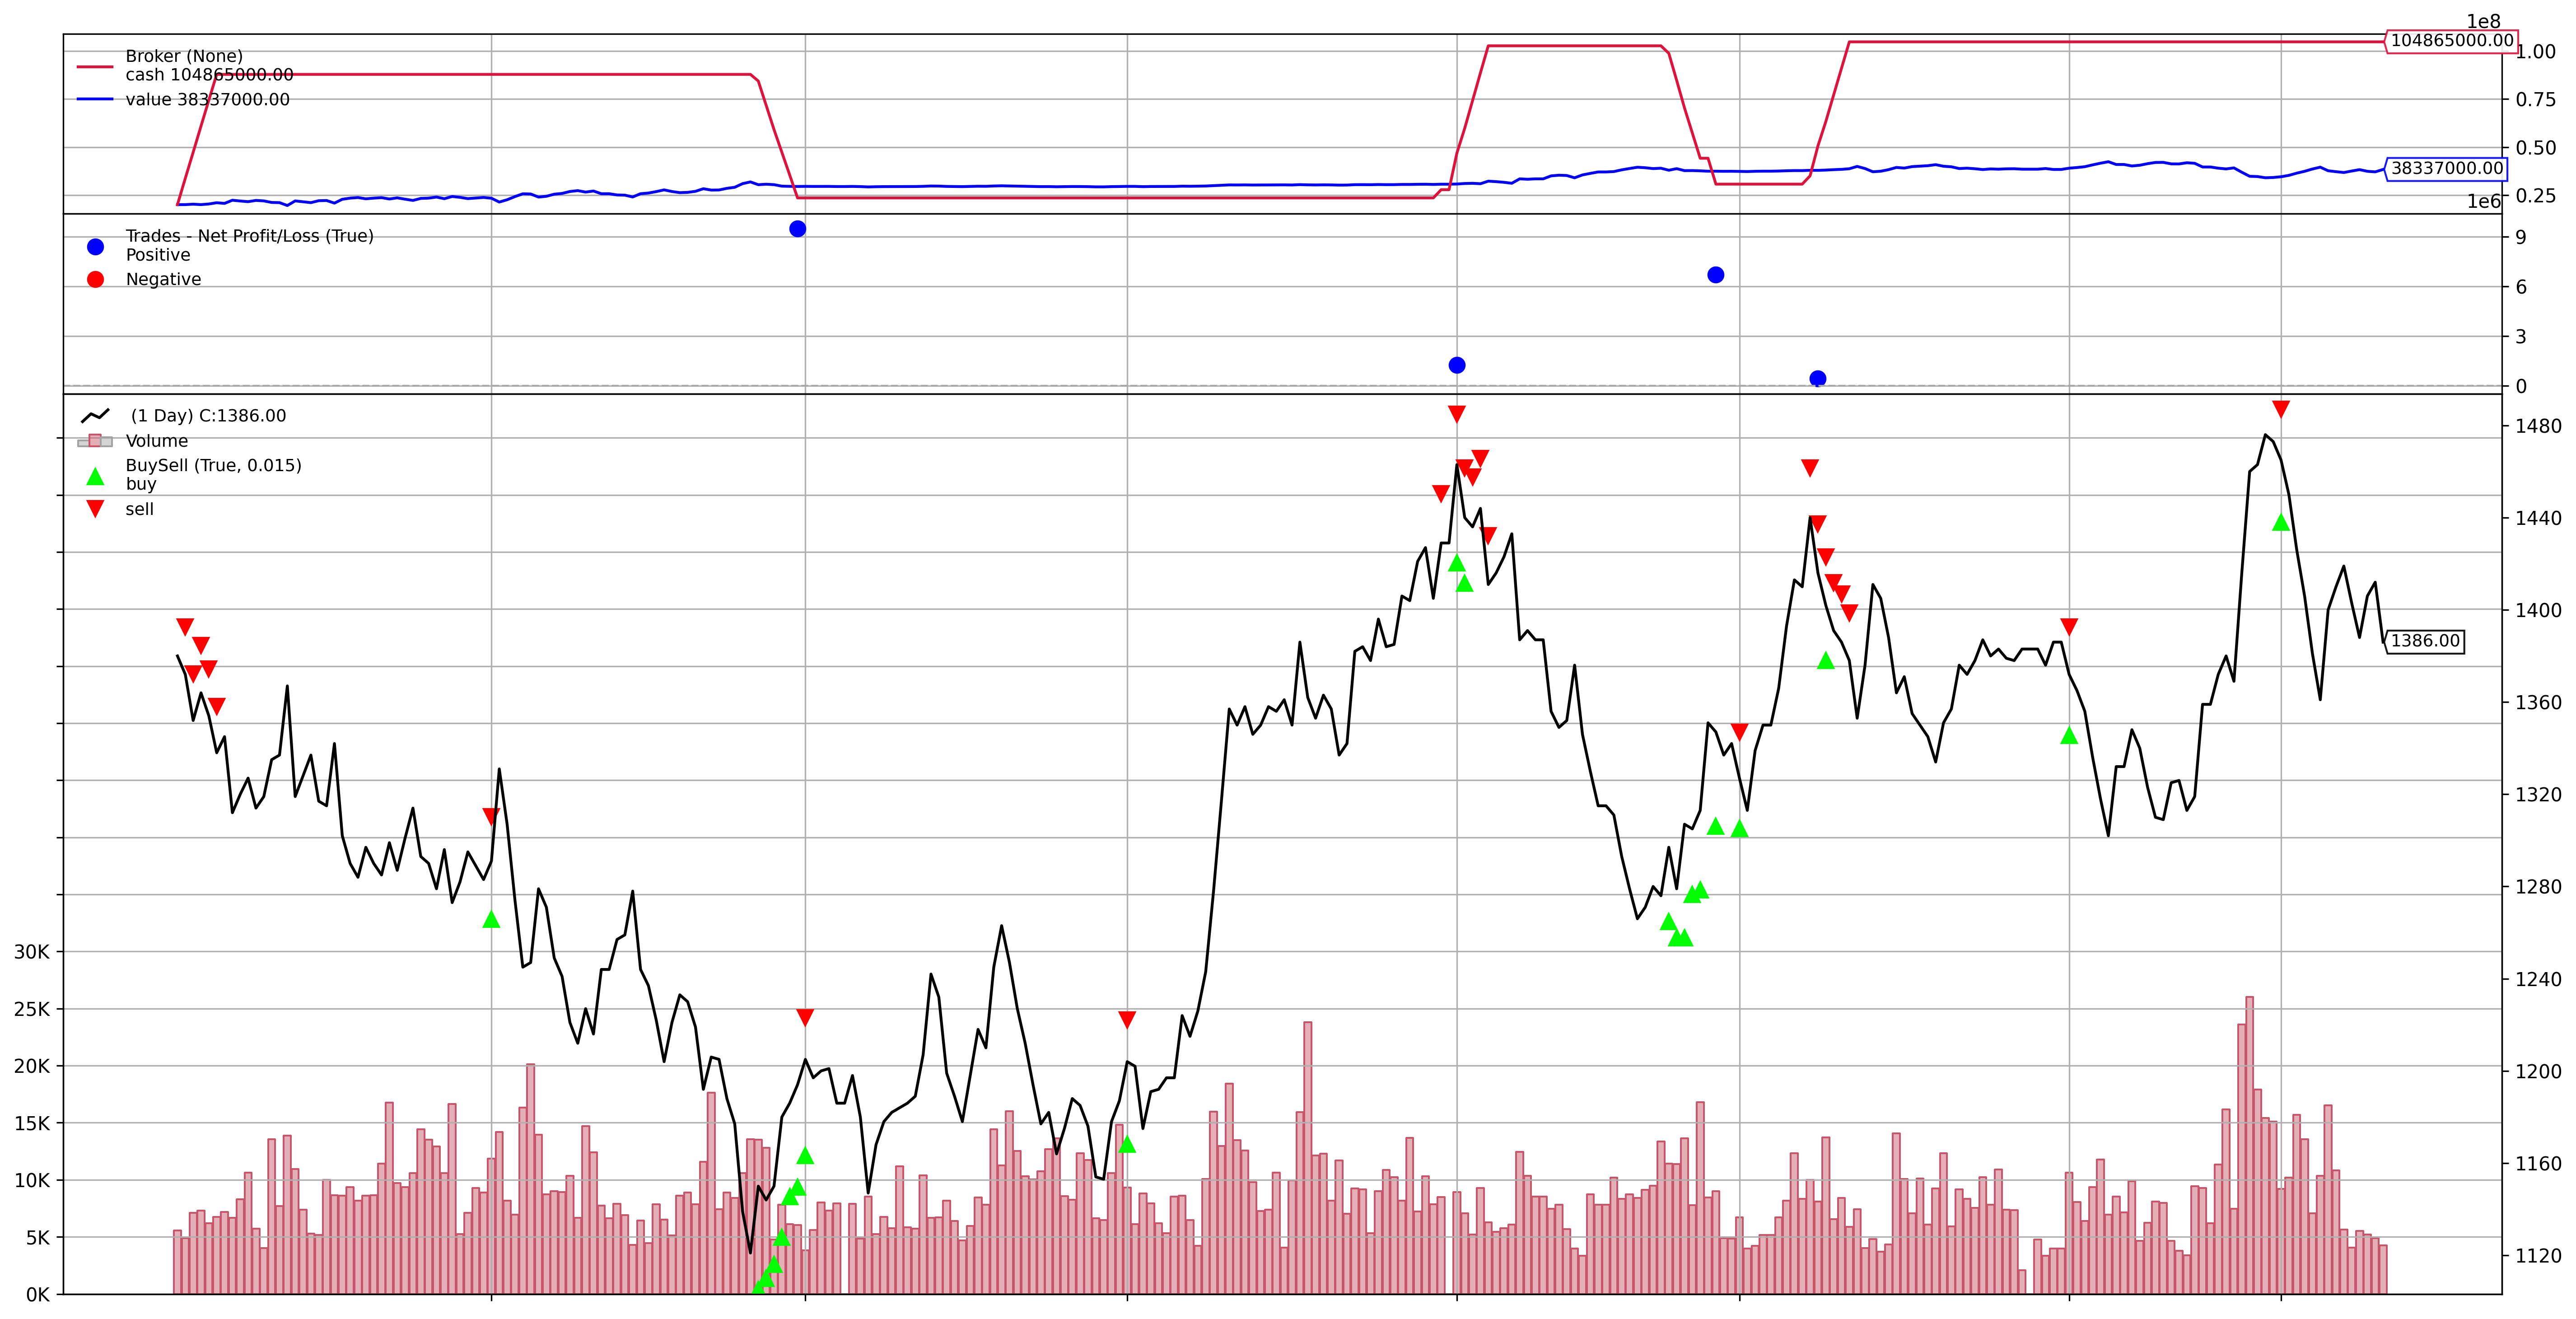

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams['axes.unicode_minus']=False
plt.rcParams['figure.figsize']=[20, 10]
plt.rcParams['figure.dpi']=300
plt.rcParams['figure.facecolor']='w'
plt.rcParams['figure.edgecolor']='k'
cerebro.plot(iplot=True)[0][0]#.savefig('1.png')

In [ ]:
#print(f"Sharpe: {results[0].analyzers.sharperatio.get_analysis()['sharperatio']:.3f}")
print(f"Norm. Annual Return: {results[0].analyzers.returns.get_analysis()['rnorm100']:.2f}%")
print(f"Max Drawdown: {results[0].analyzers.drawdown.get_analysis()['max']['drawdown']:.2f}%")
print(f"Average PNL: {results[0].analyzers.tradeAnalyze.get_analysis()['pnl']['gross']['average']:.2f}")
# # Print out the final result
print('Final Portfolio Value: %.2f' % (cerebro.broker.getvalue()-20000000))

Norm. Annual Return: 78.15%
Max Drawdown: 19.04%
Average PNL: 4437250.00
Final Portfolio Value: 18165000.00


In [ ]:
dfMaster.corr(min_periods=1)['local'].to_csv('1.csv')

# Strategy

## SMA Cross

In [ ]:
class SMACross(bt.Strategy):
    def __init__(self,param):
      self.price=self.data.close
      self.dem=[0,0,0]
      self.marketFee=param['marketFee']
      self.sma1, self.sma2 = bt.ind.SMA(period=3), bt.ind.SMA(period=5)
      self.crossover = bt.ind.CrossOver(self.sma1, self.sma2)
      self.LIMIT=param['THRESHOLD_LIMIT']

    def next(self):
      lot=300
      if not self.position:
        if self.crossover>0:
          self.buy_bracket(limitprice=self.price+self.LIMIT, 
                          stopprice=self.price-self.LIMIT,
                          size=lot*10)
          self.dem[1]+=1
          print('BUY')
        elif self.crossover<0:
          self.sell_bracket(limitprice=self.price-self.LIMIT, 
                          stopprice=self.price+self.LIMIT,
                          size=lot*10)
          #self.sell(size=100)
          self.dem[2]+=1
          print('SELL')

      self.close()
      self.dem[0]+=1
      #self.close()
      print(self.dem)

    def notify_trade(self, trade):
      date = self.data.datetime.datetime()
      #if trade.isclosed:
      print('-'*32,' NOTIFY TRADE ','-'*32)
      print('{}, Close Price: {}, Profit, Gross {}, Net {}'.format(
                                          date,
                                          trade.price,
                                          round(trade.pnl,2),
                                          round(trade.pnlcomm,2)))
      print('-'*80)


## Mean Reversion Cross

In [ ]:
class MeanReversion(bt.Strategy):
    def __init__(self,param):
      self.price=self.data.close
      self.dem=[0,0,0]
      self.marketFee=param['marketFee']
      self.boll = bt.indicators.BollingerBands(period=20, devfactor=2)
      self.LIMIT=param['THRESHOLD_LIMIT']

    def next(self):
      lot=300
      if not self.position:
        if self.data.close < self.boll.lines.bot:
          self.buy_bracket(limitprice=self.price+self.LIMIT,
                          stopprice=self.price-self.LIMIT,
                          size=lot*10)
          self.dem[1]+=1
          print('BUY')
        if self.data.close > self.boll.lines.top:
          self.sell_bracket(limitprice=self.price-self.LIMIT,
                  stopprice=self.price+self.LIMIT,
                  size=lot*10)
          self.dem[2]+=1
          print('SELL')
      self.dem[0]+=1
      self.close()

    def notify_trade(self, trade):
      date = self.data.datetime.datetime()
      #if trade.isclosed:
      print('-'*32,' NOTIFY TRADE ','-'*32)
      print('{}, Close Price: {}, Profit, Gross {}, Net {}'.format(
                                          date,
                                          trade.price,
                                          round(trade.pnl,2),
                                          round(trade.pnlcomm,2)))
      print('-'*80)


## Momentum

In [ ]:
class Momentum(bt.Strategy):
    def __init__(self,param):
      self.price=self.data.close
      self.dem=[0,0,0]
      self.marketFee=param['marketFee']
      self.LIMIT=param['THRESHOLD_LIMIT']
    
    def next(self):
      lot=300
      if not self.position:
        if self.data.close[0] > self.data.close[-1]:
          self.buy_bracket(limitprice=self.price+self.LIMIT,
                          stopprice=self.price-self.LIMIT,
                          size=lot*10)
          self.dem[1]+=1
          print('BUY')
        if self.data.close[0] < self.data.close[-1]:
          self.sell_bracket(limitprice=self.price-self.LIMIT, 
                  stopprice=self.price+self.LIMIT,
                  size=lot*10)
          
          self.dem[2]+=1
          print('SELL')
      self.dem[0]+=1
      self.close()
      print(self.dem)
      print(self.broker.get_value())
    def notify_trade(self, trade):
      date = self.data.datetime.datetime()
      #if trade.isclosed:
      print('-'*32,' NOTIFY TRADE ','-'*32)
      print('{}, Close Price: {}, Profit, Gross {}, Net {}'.format(
                                          date,
                                          trade.price,
                                          round(trade.pnl,2),
                                          round(trade.pnlcomm,2)))
      print('-'*80)


## Pair Trading

In [ ]:
class PairTrading(bt.Strategy):

  def __init__(self,param):
    self.price=self.data.close
    self.dem=[0,0,0]
    self.marketFee=param['marketFee']
    self.qty1 = 0
    self.qty2 = 0
    self.upper_limit = 2.1
    self.lower_limit = -2.1
    # Signals performed with PD.OLS :
    self.transform = btind.OLS_TransformationN(self.data0, self.data1,
                                                period=10)
    self.zscore = self.transform.zscore

  def next(self):
    lot=300
    x=(lot/2)*10
    y=(lot/2)*10
    if (self.zscore[0] > self.upper_limit):
        self.sell(data=self.data0, size=(x + self.qty1))  # Place an order for buying y + qty2 shares
        #self.close(data=self.data1, size=(y + self.qty2))
        self.buy(data=self.data1, size=(y + self.qty2))  # Place an order for selling x + qty1 shares
        # Updating the counters with new value
        self.qty1 = x  # The new open position quantity for Stock1 is x shares
        self.qty2 = y  # The new open position quantity for Stock2 is y shares
    elif (self.zscore[0] < self.lower_limit):
        #self.close(data=self.data0, size=(x + self.qty1))
        self.buy(data=self.data0, size=(x + self.qty1))  # Place an order for buying x + qty1 shares
        self.sell(data=self.data1, size=(y + self.qty2))  # Place an order for selling y + qty2 shares
        self.qty1 = x  # The new open position quantity for Stock1 is x shares
        self.qty2 = y  # The new open position quantity for Stock2 is y shares
    self.close()

  def notify_trade(self, trade):
    date = self.data.datetime.datetime()
    #if trade.isclosed:
    print('-'*32,' NOTIFY TRADE ','-'*32)
    print('{}, Close Price: {}, Profit, Gross {}, Net {}'.format(
                                        date,
                                        trade.price,
                                        round(trade.pnl,2),
                                        round(trade.pnlcomm,2)))
    print('-'*80)


In [ ]:
cerebro = bt.Cerebro()
customParam={
    'THRESHOLD_NET':0,
    'externalData': dfFilter,
    'lstAdd':lstAdd,
    'dayPred':dayPred,
    'marketFee':2
}
cerebro.addstrategy(PairTrading, customParam)
startcash = 20000000
cerebro.broker.setcash(startcash)
cerebro.broker.addcommissioninfo(comminfo)
data0 = bt.feeds.PandasData(dataname=dfBack, open='ldn_previous', high='ldn_high', 
                            low='ldn_low',close='ldn_previous', 
                            volume='ldn_volume', openinterest='ldn_oi')
cerebro.adddata(data0)
data1 = bt.feeds.PandasData(dataname=dfBack, open='ny_last', high='ny_high', 
                            low='ny_low',close='ny_last', 
                            volume='ny_volume', openinterest='ny_oi')
cerebro.adddata(data1)
cerebro.addanalyzer(bt.analyzers.SharpeRatio, riskfreerate=0.0,_name='sharperatio')
cerebro.addanalyzer(bt.analyzers.Returns,_name='returns')
cerebro.addanalyzer(bt.analyzers.DrawDown,_name='drawdown')
cerebro.addanalyzer(bt.analyzers.TradeAnalyzer,_name='tradeAnalyze')
results=cerebro.run()
